In [68]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [69]:
def initialize_layer(input_dim, output_dim, seed):
    np.random.seed(seed)
    col_shape = (output_dim, )
    z = np.zeros(col_shape, dtype=np.float64)
    y = np.zeros(col_shape, dtype=np.float64)
    b = np.ones(col_shape, dtype=np.float64)
    w = np.random.normal(0, 0.01, (input_dim, output_dim))
    return z, b, y, w

def shape_check(checks):
    for k, v in checks.items():
        try:
            assert k == v.shape
        except AssertionError:
            print("ERROR")
            print(k, v.shape)
            raise AssertionError
            
def predictNN(transformations, X):
    temp = X
    for trans in transformations:
        if callable(trans):
            temp = trans(temp)
        else:
            temp = temp.dot(trans)
    return temp.argmax(axis=1)

def scoreNN(transformations, X, y):
    preds = predictNN(transformations, X)
    return sum(preds != y.argmax(axis=1))


def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
    

In [70]:
def squared_error(y, y_hat):
    return (y - y_hat).dot((y - y_hat))

def squared_error_der(y, y_hat):
    return -1 * (y - y_hat)

def t(z):
    return np.tanh(z)

def t_der(z):
    return 1 - np.power(t(z), 2)

def g(z):
    return (1.0 / (1.0 + np.exp(-z)))

def g_der(z):
    return g(z) * (1 - g(z))

def dEdz2(z_2, y_2, y, loss_der):
    return np.multiply(g_der(z_2), loss_der(y, y_2))

def dEdz1(z_1, w_2, dEdz2_cached):
    return np.diag(t_der(z_1)).dot(w_2).dot(dEdz2_cached)

def l2_deriv(y_1, dEdz2_cached):
    return np.outer(y_1, dEdz2_cached.T)

def l1_deriv(y_0, dEdz1_cached):
    return np.outer(y_0, dEdz1_cached.T)

In [1]:
def trainNN(XTrain, yTrain, **kwargs):
    input_layer_dim = len(XTrain[0])
    hidden_layer_dim = kwargs.get("hidden_layer_dim", 200)
    output_layer_dim = kwargs.get("output_layer_dim", len(yTrain[0]))
    XVal = kwargs.get("XVal", None)
    yVal = kwargs.get("yVal", None)
    num_iters = kwargs.get("num_iters", 1000)
    every_iter = kwargs.get("every_iter", 1000)
    eta = kwargs.get("eta", 0.01)
    seed = kwargs.get("seed", 50)
    z_1, b_1, y_1, w_1 = initialize_layer(len(XTrain[0,:]), hidden_layer_dim, seed)
    z_2, b_2, y_2, w_2 = initialize_layer(hidden_layer_dim, output_layer_dim, seed)

    training_errors = []
    validation_errors = []
    iters = []
    for _ in range(num_iters):
        ex_index = np.random.choice(len(XTrain), 1)
        y_0 = XTrain[ex_index].reshape(input_layer_dim,)
        y = yTrain[ex_index].reshape(output_layer_dim,)
        
        # layer 1
        y_0.dot(w_1, out=z_1)
        np.tanh(z_1 + b_1, out=y_1)
        
        # layer 2
        y_1.dot(w_2, out=z_2)
        np.tanh(z_2 + b_2, out=y_2) # tanh

#         y_2 = g(z_2 + b_2)
    
        delta2 = -(y - y_2) * t_der(z_2)
#         delta2 = -(y - y_2) * g_der(z_2)
        dEdw2 = np.outer(y_1, delta2)
        delta1 = delta2.dot(w_2.T).dot(t_der(z_1))
        dEdw1 = np.outer(y_0, delta1)
        
        # updates
        if _ == int(num_iters/10):
            eta = 0.01
            print("update eta", eta)
        if _ == int(num_iters/3):
            eta = 0.001
            print("update eta", eta)
        if _ == 3 * int(num_iters/4):
            eta = 0.0001
            print("update eta", eta)
        if _ == 9 * int(num_iters/10):
            eta = 0.00001
            print("update eta", eta)

        w_1 -= eta * dEdw1        
        w_2 -= eta * dEdw2
        b_1 -= eta * np.sum(delta1, axis=0)
        b_2 -= eta * np.sum(delta2, axis=0)


        sequence = [w_1, lambda x: x + b_1, np.tanh, w_2, lambda x: x + b_2, np.tanh]
#         sequence = [w_1, lambda x: x + b_1, np.tanh, w_2, lambda x: x + b_2, g]
        if _ % every_iter == 0: 
            training_error = scoreNN(sequence, XTrain, yTrain)
            training_errors.append(training_error/len(XTrain))
            
            if XVal != None:
                validation_error = scoreNN(sequence, XVal, yVal)
                validation_errors.append(validation_error/len(XVal))
#                 print("Validation Error:", validation_error/len(XVal))
            else:
                validation_errors.append(0)


            iters.append(_)
#             print("Number Wrong:", training_error, "Training Error:", training_error/len(XTrain), "On Iter", _)
        if kwargs.get("debug", False) and _ % 500 == 0:
            training_error = scoreNN(sequence, XTrain, yTrain)
            loss = squared_error(y, y_2)
            training_errors.append(training_error)
            losses.append(loss)
            iters.append(_)
            plot_mnist_digit(y_0.reshape(28,28))
            print("Y value", y.argmax())
            print("predicted:", y_2.argmax(), "predicted act:", y_2[y_2.argmax()], 
                  "\nActual:", y.argmax(), "actual act:", y_2[y.argmax()],
                  "\nAverage :", y_2.mean(),
                  "Min and Max :", min(y_2), max(y_2))
                
    pd.DataFrame({"training errors": training_errors, 
                  "validation errors": validation_errors, 
                  "iters": iters}).plot(x='iters')
    return {
        "model":sequence,
        "training errors": training_errors,
        "validation errors": validation_errors,
        "iters": iters,
        "params": kwargs
    }

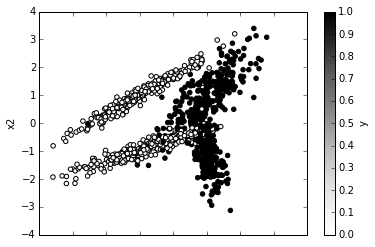

In [102]:
from sklearn.datasets import make_classification

X, y = make_classification(1100, n_classes=2, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
pd.DataFrame({"x1":X[:,0], "x2":X[:,1],"y":y}).plot(kind='scatter',x='x1', y='x2', c='y')
y = pd.get_dummies(y).values

update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05


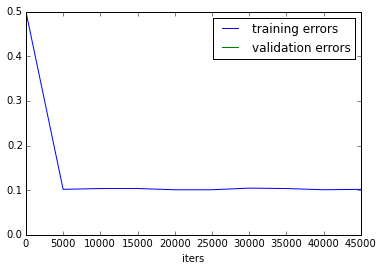

In [103]:
model = trainNN(X, y, hidden_layer_dim=50, num_iters=50000, every_iter=5000)

In [104]:
def load_training_data():
    raw_train_images = scipy.io.loadmat("dataset/train.mat")['train_images'].T.reshape(60000, 784) / 255.0

    raw_train_labels = scipy.io.loadmat("dataset/train.mat")['train_labels'].reshape(60000, )

    tX, XVal, ty, yVal = train_test_split(raw_train_images, raw_train_labels,
                                          test_size=0.25, random_state=10)
    tX = tX
    XVal = XVal

    return {"X": tX, "y": ty, "XVal": XVal, "yVal": yVal}
train_dict = load_training_data()
X = train_dict['X']
y = train_dict['y']
XVal = train_dict['XVal']
yVal = pd.get_dummies(train_dict['yVal']).values
print("Mean of y:", y.mean())
print("Y values:", len(pd.Series(y).unique()))
print("Num Trainings", len(X))
y = pd.get_dummies(y).values

Mean of y: 4.44715555556
Y values: 10
Num Trainings 45000


In [105]:
random_iters = np.random.random_integers(400000, 2000000,5)
print(random_iters)

[ 404535 1505871  837558 1037256  802334]


Seed: 997
update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05
Seed: 370
update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05
Seed: 178
update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05
Seed: 229
update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05
Seed: 659
update eta 0.01
update eta 0.001
update eta 0.0001
update eta 1e-05


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:64: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


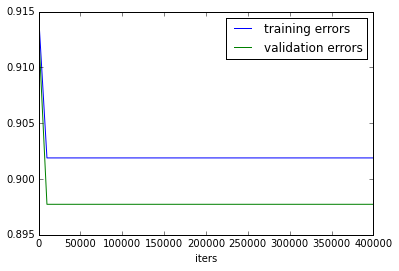

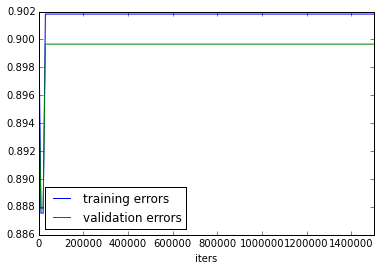

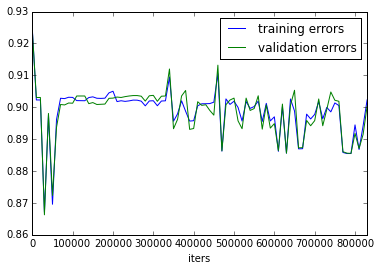

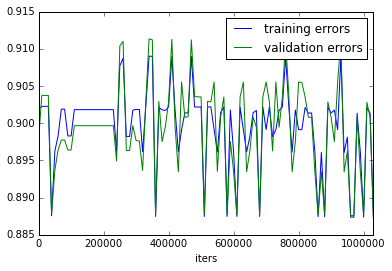

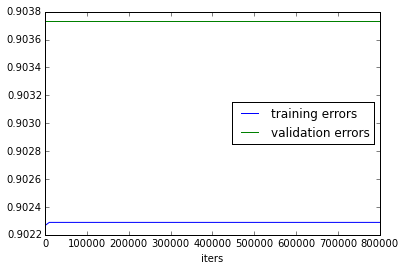

In [106]:
models = []
import datetime
for ri in random_iters:
    s = np.random.randint(1000)
    print("Seed:", s)
    start = datetime.datetime.now()
    model = trainNN(X, y, 
                    XVal=XVal, yVal=yVal, 
                    eta=0.05, seed=s, 
                    hidden_layer_dim=200, 
                    num_iters=ri, every_iter=10000)
    end = datetime.datetime.now()
    total = end - start
    model['total_time'] = total
    models.append(model)

In [100]:
import pickle

for num, mod in enumerate(models):
    with open("Model %i, final error %.2f.pkl" % (num, mod['training errors'][-1]), 'wb') as f:
        newobj = {
            'params':mod['params'],
            'training errors': mod['training errors'],
            'validation errors': mod['validation errors']
        }
        pickle.dump(newobj,f)